# Return Differences between Trading and Non-trading Hours


### Required Libraries

The analysis uses these key libraries:
- **pandas**: For efficient data manipulation and time series analysis
- **numpy**: For high-performance numerical operations
- **scipy.stats**: For advanced statistical calculations
- **matplotlib**: For creating static, animated, and interactive visualizations
- **seaborn**: For enhanced statistical data visualization



In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading

#### Dataset Description
The data contains minute-by-minute trading information with the following columns:
- **timestamp**: Time of the trade
- **v**: Volume
- **vw**: Volume-weighted average price
- **o**: Open price
- **c**: Close price
- **h**: High price
- **l**: Low price
- **n**: Number of trades

#### Data Period
- Start Date: December 2022
- Frequency: 1-minute intervals
- Trading Hours: 9:30 AM - 4:00 PM EST

#### Data Source
Raw data sourced from Polygon.io, processed and stored in the project's GitHub repository.

## Note on Data Quality
- The dataset has been pre-cleaned and filtered for regular trading hours
- Missing values and outliers have been handled in the preprocessing stage
- Timestamps are in EST (Eastern Standard Time)

In [2]:

aapl = pd.read_csv('https://raw.githubusercontent.com/RishikeshMahadevan/Project-File-Return-Differences-between-Trading-and-Non-trading-Hours/main/Datasets/AAPL_data%20(1).csv')
amzn = pd.read_csv('https://raw.githubusercontent.com/RishikeshMahadevan/Project-File-Return-Differences-between-Trading-and-Non-trading-Hours/main/Datasets/AMZN_data.csv')

In [3]:
aapl.head()


,timestamp,v,vw,o,c,h,l,n
0,2022-12-29 09:00:00,3382.0,126.6802,126.82,126.52,126.82,126.52,69
1,2022-12-29 09:01:00,595.0,126.5543,126.59,126.59,126.59,126.59,38
2,2022-12-29 09:02:00,1802.0,126.5493,126.55,126.55,126.55,126.55,58
3,2022-12-29 09:03:00,3324.0,126.5999,126.59,126.62,126.62,126.59,69
4,2022-12-29 09:04:00,5029.0,126.6206,126.54,126.66,126.70,126.54,76


# Data Preparation and Return Calculation

## Overview
This section contains the core functions for processing market data and calculating returns across different trading intervals. The analysis splits each trading day into four distinct periods to study return patterns:
- Night Return: Previous day's close to today's open (4:00 PM to 9:30 AM)
- AM Return: Morning session (9:30 AM to 10:30 AM)
- Mid Return: Mid-day session (10:30 AM to 3:00 PM)
- PM Return: Afternoon session (3:00 PM to 4:00 PM)

## Key Functions

### `prepare_trading_data(df)`
- Converts timestamp data to datetime format
- Creates separate time and date columns
- Filters data for regular trading hours (9:30 AM to 4:00 PM)
- Returns cleaned and filtered DataFrame

### `get_previous_trading_close(df, current_date)`
- Finds the previous trading day's closing price
- Handles weekends and holidays by looking back up to 5 days
- Essential for calculating overnight returns

### `calculate_interval_returns(df)`
- Calculates returns for each trading interval
- Uses vectorized operations where possible
- Handles missing data and edge cases
- Returns a DataFrame with four return columns (Night, AM, Mid, PM)

### `analyze_returns(returns_df, stock_name)`
- Computes key statistics for each return series:
  - Mean and Standard Deviation
  - Quartile Analysis (25th, 75th percentiles)
  - Higher Moments (Skewness, Kurtosis)
  - Sample Size (Count)
- Provides comprehensive statistical summary


## Notes
- All calculations use simple returns: (P2-P1)/P1
- Missing data is handled gracefully with np.nan
- The code includes error handling for edge cases

In [4]:
def prepare_trading_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Create time column
    df['time'] = df['timestamp'].dt.time
    df['date'] = df['timestamp'].dt.date
    
    # Filter for regular trading hours (9:30 AM to 4:00 PM)
    market_open = pd.to_datetime('09:30:00').time()
    market_close = pd.to_datetime('16:00:00').time()
    
    trading_hours_df = df[
        (df['time'] >= market_open) & 
        (df['time'] <= market_close)
    ].copy()
    
    return trading_hours_df

def get_previous_trading_close(df, current_date):
    current_date = pd.to_datetime(current_date)
    
    # Look back up to 5 days to find the previous trading day. 
    # This is to account for weekends and holidays
    for i in range(1, 5):
        prev_date = current_date - pd.Timedelta(days=i)
        prev_day_data = df[df['date'] == prev_date.date()]
        
        if not prev_day_data.empty:
            return prev_day_data['c'].iloc[-1]  # Return the closing price
    
    return None

def calculate_interval_returns(df):
    df = prepare_trading_data(df)
    returns_dict = {}
    
    # Sort dataframe by timestamp to ensure chronological order
    df = df.sort_values('timestamp')
    
    for date in sorted(df['date'].unique()):
        day_data = df[df['date'] == date]
        
        # Night Return (Previous trading day close to 9:30 open)
        try:
            prev_close = get_previous_trading_close(df, date)
            if prev_close is not None:
                today_open = day_data['o'].iloc[0]   # Today's open at 9:30 AM
                night_return = (today_open - prev_close) / prev_close
            else:
                night_return = np.nan
        except:
            night_return = np.nan
    
        # AM Return (9:30 to 10:30)
        try:
            open_price = day_data['o'].iloc[0]
            am_cutoff = pd.to_datetime('10:30:00').time()
            am_data = day_data[day_data['time'] <= am_cutoff]
            if not am_data.empty:
                am_close = am_data['c'].iloc[-1]
                am_return = (am_close - open_price) / open_price
            else:
                am_return = np.nan
        except:
            am_return = np.nan
            
        # Mid Return (10:30 to 15:00)
        try:
            mid_start = pd.to_datetime('10:30:00').time()
            mid_end = pd.to_datetime('15:00:00').time()
            mid_start_price = day_data[day_data['time'] <= mid_start]['c'].iloc[-1]
            mid_end_price = day_data[day_data['time'] <= mid_end]['c'].iloc[-1]
            mid_return = (mid_end_price - mid_start_price) / mid_start_price
        except:
            mid_return = np.nan
            
        # PM Return (15:00 to 16:00)
        try:
            pm_start = pd.to_datetime('15:00:00').time()
            pm_start_price = day_data[day_data['time'] <= pm_start]['c'].iloc[-1]
            pm_close = day_data['c'].iloc[-1]
            pm_return = (pm_close - pm_start_price) / pm_start_price
        except:
            pm_return = np.nan
            
        returns_dict[date] = {
            'Night_Return': night_return,
            'AM_Return': am_return,
            'Mid_Return': mid_return,
            'PM_Return': pm_return
        }
    
    # Convert to DataFrame and calculate statistics as before
    returns_df = pd.DataFrame.from_dict(returns_dict, orient='index')
    
    return returns_df

# Calculate returns and create summary statistics
def analyze_returns(returns_df, stock_name):
    # Calculate detailed statistics
    stats_dict = {}
    for column in returns_df.columns:
        data = returns_df[column].dropna()
        stats_dict[column] = {
            'Mean (%)': data.mean() * 100,
            'Std (%)': data.std() * 100,
            '25th (%)': data.quantile(0.25) * 100,
            '75th (%)': data.quantile(0.75) * 100,
            'Skewness': data.skew(),
            'Kurtosis': data.kurtosis(),
            'Count': len(data)
        }
    
    stats_df = pd.DataFrame(stats_dict)
    
    print(f"\n{stock_name} Return Statistics:")
    print(stats_df)
    
    return stats_df

# Calculate and analyze returns
aapl_returns = calculate_interval_returns(aapl)
amzn_returns = calculate_interval_returns(amzn)

aapl_stats = analyze_returns(aapl_returns, 'AAPL')
amzn_stats = analyze_returns(amzn_returns, 'AMZN')


AAPL Return Statistics:
          Night_Return   AM_Return  Mid_Return   PM_Return
Mean (%)     -0.015415   -0.000009    0.125733    0.042571
Std (%)       1.003109    0.185971    0.981168    0.395668
25th (%)     -0.444873   -0.082060   -0.426709   -0.187258
75th (%)      0.493223    0.099620    0.645093    0.277688
Skewness     -1.344135   -0.603789    0.685343    0.063451
Kurtosis     18.714945    5.855384    4.986824    1.349914
Count       500.000000  501.000000  501.000000  501.000000

AMZN Return Statistics:
          Night_Return   AM_Return  Mid_Return   PM_Return
Mean (%)      0.183251    0.005970   -0.001829    0.034043
Std (%)       1.375128    0.211070    1.209773    0.566365
25th (%)     -0.400676   -0.106556   -0.717625   -0.276213
75th (%)      0.776947    0.101833    0.719550    0.335060
Skewness      0.731462   -0.572106    0.036459    0.392691
Kurtosis     12.766467    5.390720    0.646881    2.227305
Count       500.000000  501.000000  501.000000  501.000000


t 

In [5]:
aapl_returns

,Night_Return,AM_Return,Mid_Return,PM_Return
2022-12-29,NaN,-0.000315,0.017826,0.006403
2022-12-30,-0.007826,0.001164,-0.009302,0.007199
2023-01-03,0.017091,-0.000917,-0.027676,-0.010654
2023-01-04,0.002186,0.002379,0.000396,0.001740
2023-01-05,-0.002132,0.003956,0.002916,-0.007072
...,...,...,...,...
2024-12-19,-0.022494,0.000525,0.004237,0.006067
2024-12-20,-0.010943,0.001575,-0.004777,0.013024
2024-12-23,0.021874,-0.001057,-0.002194,-0.003848
2024-12-24,0.006582,0.000117,0.005442,0.002842


# Strategy Implementation and Performance Analysis

## Portfolio Construction and Performance Evaluation
This section implements the core trading strategies and their performance analysis using vectorized operations for optimal computational efficiency.

### 1. Strategy Return Calculation (`calculate_period_strategy_returns`)
- **Purpose**: Calculates returns for different trading periods using vectorized operations
- **Implementation Details**:
  - Initial capital: $100,000 split equally between AAPL and AMZN
  - Tracks individual position values for each time period
  - Calculates cumulative returns using `.cumprod()`
  - Includes Buy & Hold benchmark strategy
  
### 2. Performance Metrics (`calculate_metrics_vectorized`)
Calculates key performance metrics for each strategy:
- **Return Metrics**:
  - Total Return (%)
  - Annualized Return (%)
  - Daily Standard Deviation (%)
- **Risk Metrics**:
  - Sharpe Ratio (assuming 2% annual risk-free rate)
  - Maximum Drawdown (%)
- **Trading Statistics**:
  - Win Rate (%)
  - Profit Factor (gross profits / gross losses)
  - Number of Trades

### 3. Visualization (`plot_strategy_comparison`)
Creates comprehensive performance visualizations:
- **Upper Panel**: Portfolio value evolution for all strategies
- **Lower Panel**: Drawdown analysis
- **Additional Plot**: Return distribution comparison using KDE

### Key Features
1. **Vectorized Operations**:
   - Uses pandas/numpy operations for efficiency
   - Minimizes loops and iterative calculations
   - Optimized for large datasets

2. **Risk Management**:
   - Tracks drawdowns continuously
   - Monitors risk-adjusted returns
   - Analyzes return distributions

3. **Performance Comparison**:
   - Compares different time period strategies
   - Benchmarks against Buy & Hold
   - Provides comprehensive statistical analysis

### Notes
- All calculations use vectorized operations for optimal performance
- Returns are calculated on a percentage basis
- Risk-free rate is assumed to be 2% annually
- Drawdowns are calculated using expanding maximum values

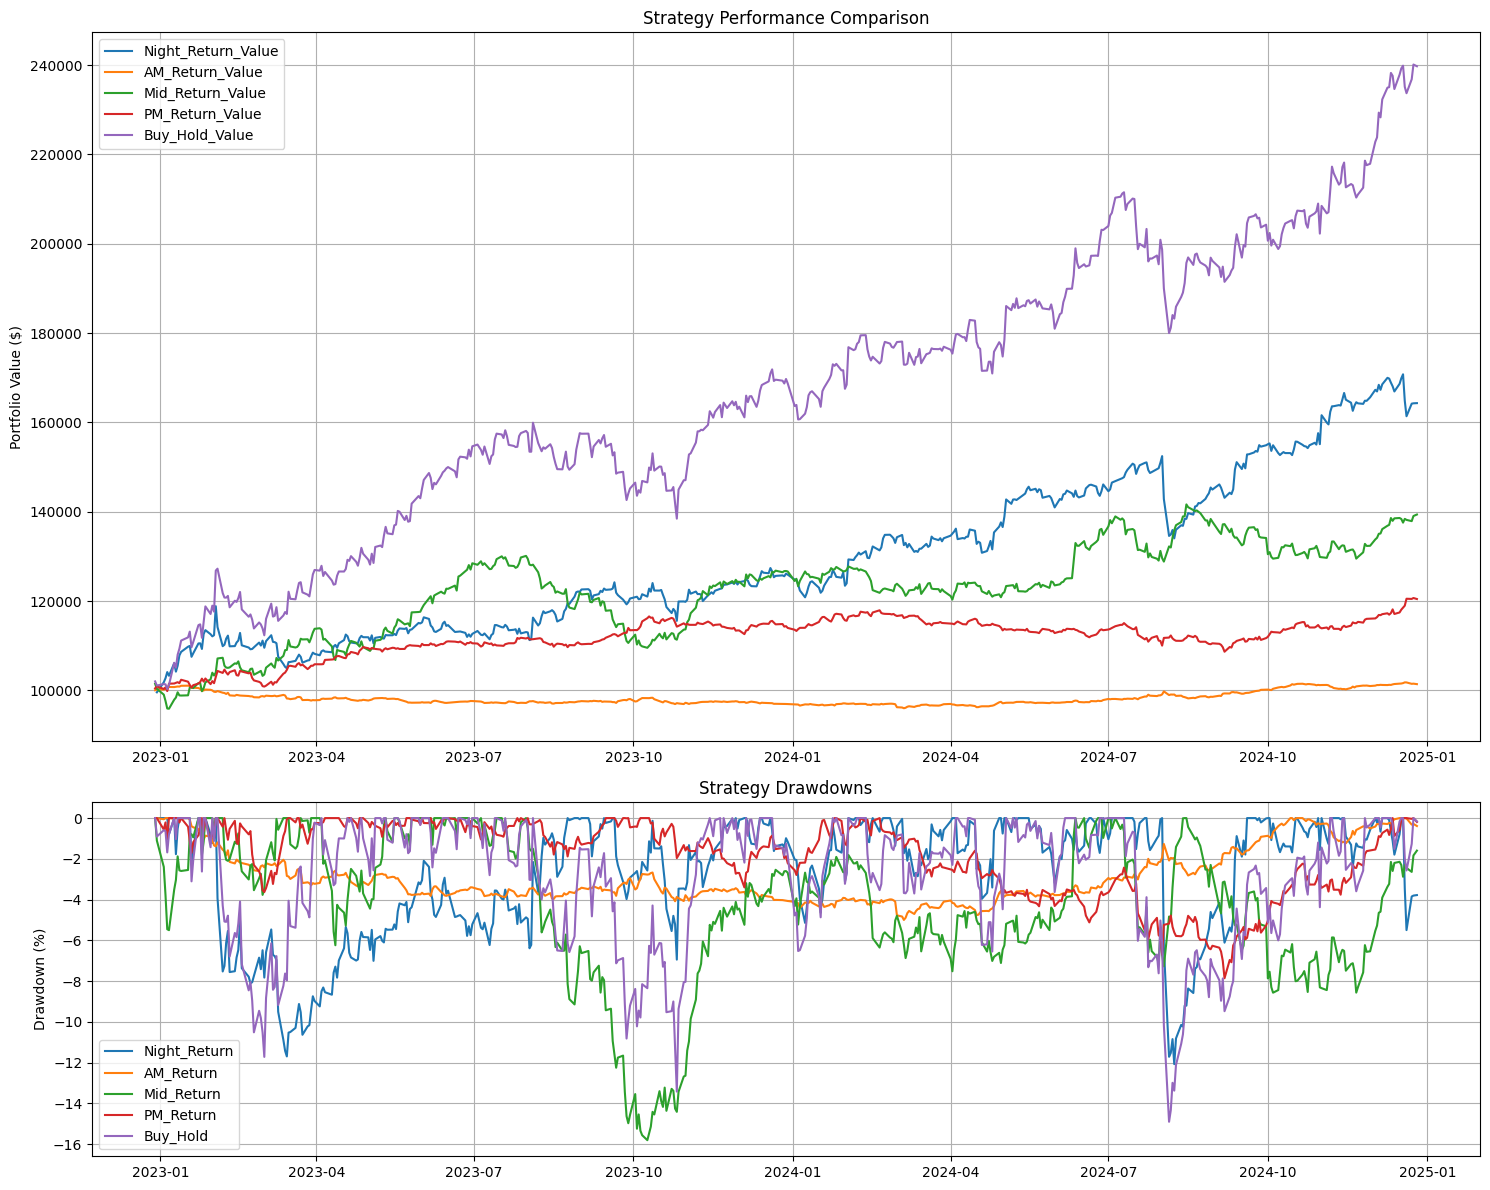


Strategy Performance Metrics:
                      Night_Return  AM_Return  Mid_Return  PM_Return  Buy_Hold
Total_Return(%)              65.01       1.36       37.33      19.90    134.95
Annualized_Return(%)         30.64       0.72       18.48       9.82     57.84
Sharpe_Ratio                  1.46      -0.50        1.07       1.12      1.91
Max_Drawdown(%)             -12.08      -5.00      -15.81      -7.86    -14.91
Win_Rate(%)                  57.52      51.80       54.00      52.80     58.20
Profit_Factor                 1.34       1.05        1.22       1.27      1.41
Number_of_Trades            499.00     500.00      500.00     500.00    500.00
Daily_Std(%)                  1.07       0.16        0.88       0.41      1.44


<Figure size 1200x600 with 0 Axes>

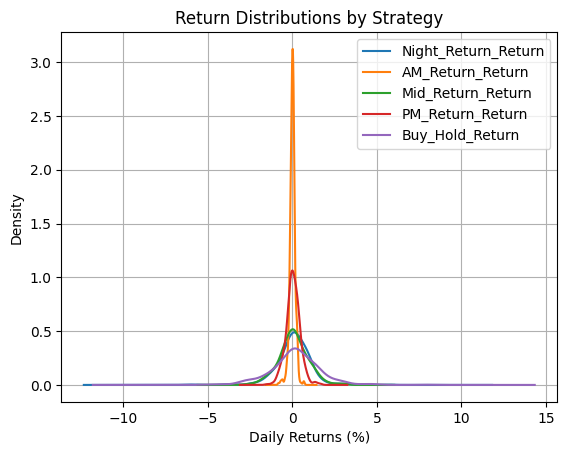

In [6]:
def calculate_period_strategy_returns(aapl_returns, amzn_returns, initial_capital=100000):
    """
    Calculate strategy returns using vectorized operations
    """
    capital_per_stock = initial_capital / 2
    periods = ['Night_Return', 'AM_Return', 'Mid_Return', 'PM_Return']
    
    # Initialize portfolio DataFrame
    portfolio = pd.DataFrame(index=aapl_returns.index)
    
    # Vectorized calculations for each period
    for period in periods:
        # Calculate position values using cumulative returns
        portfolio[f'AAPL_{period}_Position'] = capital_per_stock * (1 + aapl_returns[period]).cumprod()
        portfolio[f'AMZN_{period}_Position'] = capital_per_stock * (1 + amzn_returns[period]).cumprod()
        
        # Total portfolio value for this period
        portfolio[f'{period}_Value'] = portfolio[f'AAPL_{period}_Position'] + portfolio[f'AMZN_{period}_Position']
        portfolio[f'{period}_Return'] = portfolio[f'{period}_Value'].pct_change()
    
    # Buy & Hold strategy (using cumulative returns of daily total returns)
    aapl_daily_return = (1 + aapl_returns).prod(axis=1) - 1
    amzn_daily_return = (1 + amzn_returns).prod(axis=1) - 1
    
    portfolio['AAPL_BH_Position'] = capital_per_stock * (1 + aapl_daily_return).cumprod()
    portfolio['AMZN_BH_Position'] = capital_per_stock * (1 + amzn_daily_return).cumprod()
    portfolio['Buy_Hold_Value'] = portfolio['AAPL_BH_Position'] + portfolio['AMZN_BH_Position']
    portfolio['Buy_Hold_Return'] = portfolio['Buy_Hold_Value'].pct_change()
    
    return portfolio

def calculate_metrics_vectorized(portfolio):
    """
    Calculate all metrics using vectorized operations
    """
    strategies = ['Night_Return', 'AM_Return', 'Mid_Return', 'PM_Return', 'Buy_Hold']
    
    # Initialize metrics DataFrame
    metrics = pd.DataFrame(index=['Total_Return(%)', 'Annualized_Return(%)', 'Sharpe_Ratio', 
                                'Max_Drawdown(%)', 'Win_Rate(%)', 'Profit_Factor', 
                                'Number_of_Trades', 'Daily_Std(%)'])
    
    rf_daily = 0.02/252  # Annual risk-free rate to daily
    
    for strategy in strategies:
        returns = portfolio[f'{strategy}_Return'].dropna()
        values = portfolio[f'{strategy}_Value'].dropna()
        
        # Vectorized calculations
        total_return = (values.iloc[-1] / values.iloc[0] - 1) * 100
        excess_returns = returns - rf_daily
        sharpe = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
        drawdown = (values / values.expanding().max() - 1).min() * 100
        win_rate = (returns > 0).mean() * 100
        
        # Profit factor calculation
        positive_returns = returns[returns > 0].sum()
        negative_returns = abs(returns[returns < 0].sum())
        profit_factor = positive_returns / negative_returns if negative_returns != 0 else np.inf
        
        metrics[strategy] = [
            total_return,
            ((1 + returns.mean()) ** 252 - 1) * 100,  # Annualized return
            sharpe,
            drawdown,
            win_rate,
            profit_factor,
            len(returns),
            returns.std() * 100
        ]
    
    return metrics

def plot_strategy_comparison(portfolio, metrics):
    """
    Create visualization using vectorized operations
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])
    
    # Plot all strategy values at once
    value_columns = [col for col in portfolio.columns if col.endswith('_Value')]
    portfolio[value_columns].plot(ax=ax1)
    
    ax1.set_title('Strategy Performance Comparison')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.grid(True)
    
    # Calculate all drawdowns at once
    drawdowns = pd.DataFrame(index=portfolio.index)
    for strategy in ['Night_Return', 'AM_Return', 'Mid_Return', 'PM_Return', 'Buy_Hold']:
        values = portfolio[f'{strategy}_Value']
        drawdowns[strategy] = (values / values.expanding().max() - 1) * 100
    
    # Plot all drawdowns
    drawdowns.plot(ax=ax2)
    ax2.set_title('Strategy Drawdowns')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

# Calculate results using vectorized operations
portfolio = calculate_period_strategy_returns(aapl_returns, amzn_returns)
metrics = calculate_metrics_vectorized(portfolio)

# Plot results
fig = plot_strategy_comparison(portfolio, metrics)
plt.show()

# Print metrics
print("\nStrategy Performance Metrics:")
print(metrics.round(2))

# Vectorized calculation of return distributions
plt.figure(figsize=(12, 6))
return_columns = [col for col in portfolio.columns if col.endswith('_Return')]
portfolio[return_columns].multiply(100).plot(kind='kde')
plt.title('Return Distributions by Strategy')
plt.xlabel('Daily Returns (%)')
plt.ylabel('Density')
plt.grid(True)
plt.show()